In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [1]:
!pip install -q rmidi==0.0.14

# Importing Libraries

In [2]:
import rmidi.MIDI as M
import rmidi.mutils as mm
import rmidi.analyser as analyser

In [100]:
import music21
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [25,9]
plt.rcParams['xtick.labelsize']=24
plt.rcParams['ytick.labelsize']=24
import numpy, math
import matplotlib.gridspec as gridspec
import copy
import numba

# Analysing midi file on event occurnece

For now just analysing one song Believer by ***Imagine Dragons***

In [30]:
# f = '/content/gdrive/My Drive/Music.........../midis/Believer_-_Imagine_Dragons.mid'
f = 'Believer_Imagine_Dragons.mid'


In [52]:

ana = analyser.Analyser(f)
evt_stats = ana.stats(True)


fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, :])
ax.bar(evt_stats['channel'].keys(), evt_stats['channel'].values())
ax.set_ylabel('frequency of occurence')
ax.set_xlabel('channel event')
v = ['meta', 'sys']
for i in range(2):
    ax = fig.add_subplot(gs[1, i])
    ax.bar(evt_stats[v[i]].keys(), evt_stats[v[i]].values())
    ax.set_ylabel('%s event' % v[i])
    ax.set_xlabel('%s event' % v[i])
    if i == 0:
        for tick in ax.get_xticklabels():
            tick.set_rotation(55)
fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()

plt.show()



NameError: name 'analyser' is not defined

# The Frequency Analysis for Chords
***The Intra Instrument ployphony*** frequencies in chords and there correlation and its factor

In [55]:
def plot(x, y, xlab, ylab, legend):
    plt.plot(x, y, label=legend)
    plt.xlabel(xlab, fontsize=40)
    plt.ylabel(ylab, fontsize=40)
    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.legend()
    plt.show()

### sin : It calculates the pure sin wave value for 
1. freq : frequency of wave
2. time : timespan of wave
3. resolution : samples per frequency tick, apart from default 4 * freq
4. mx : max frequency, if any

<b>Note</b>   &emsp; &emsp;  <i>tick = 4 * freq </i>  

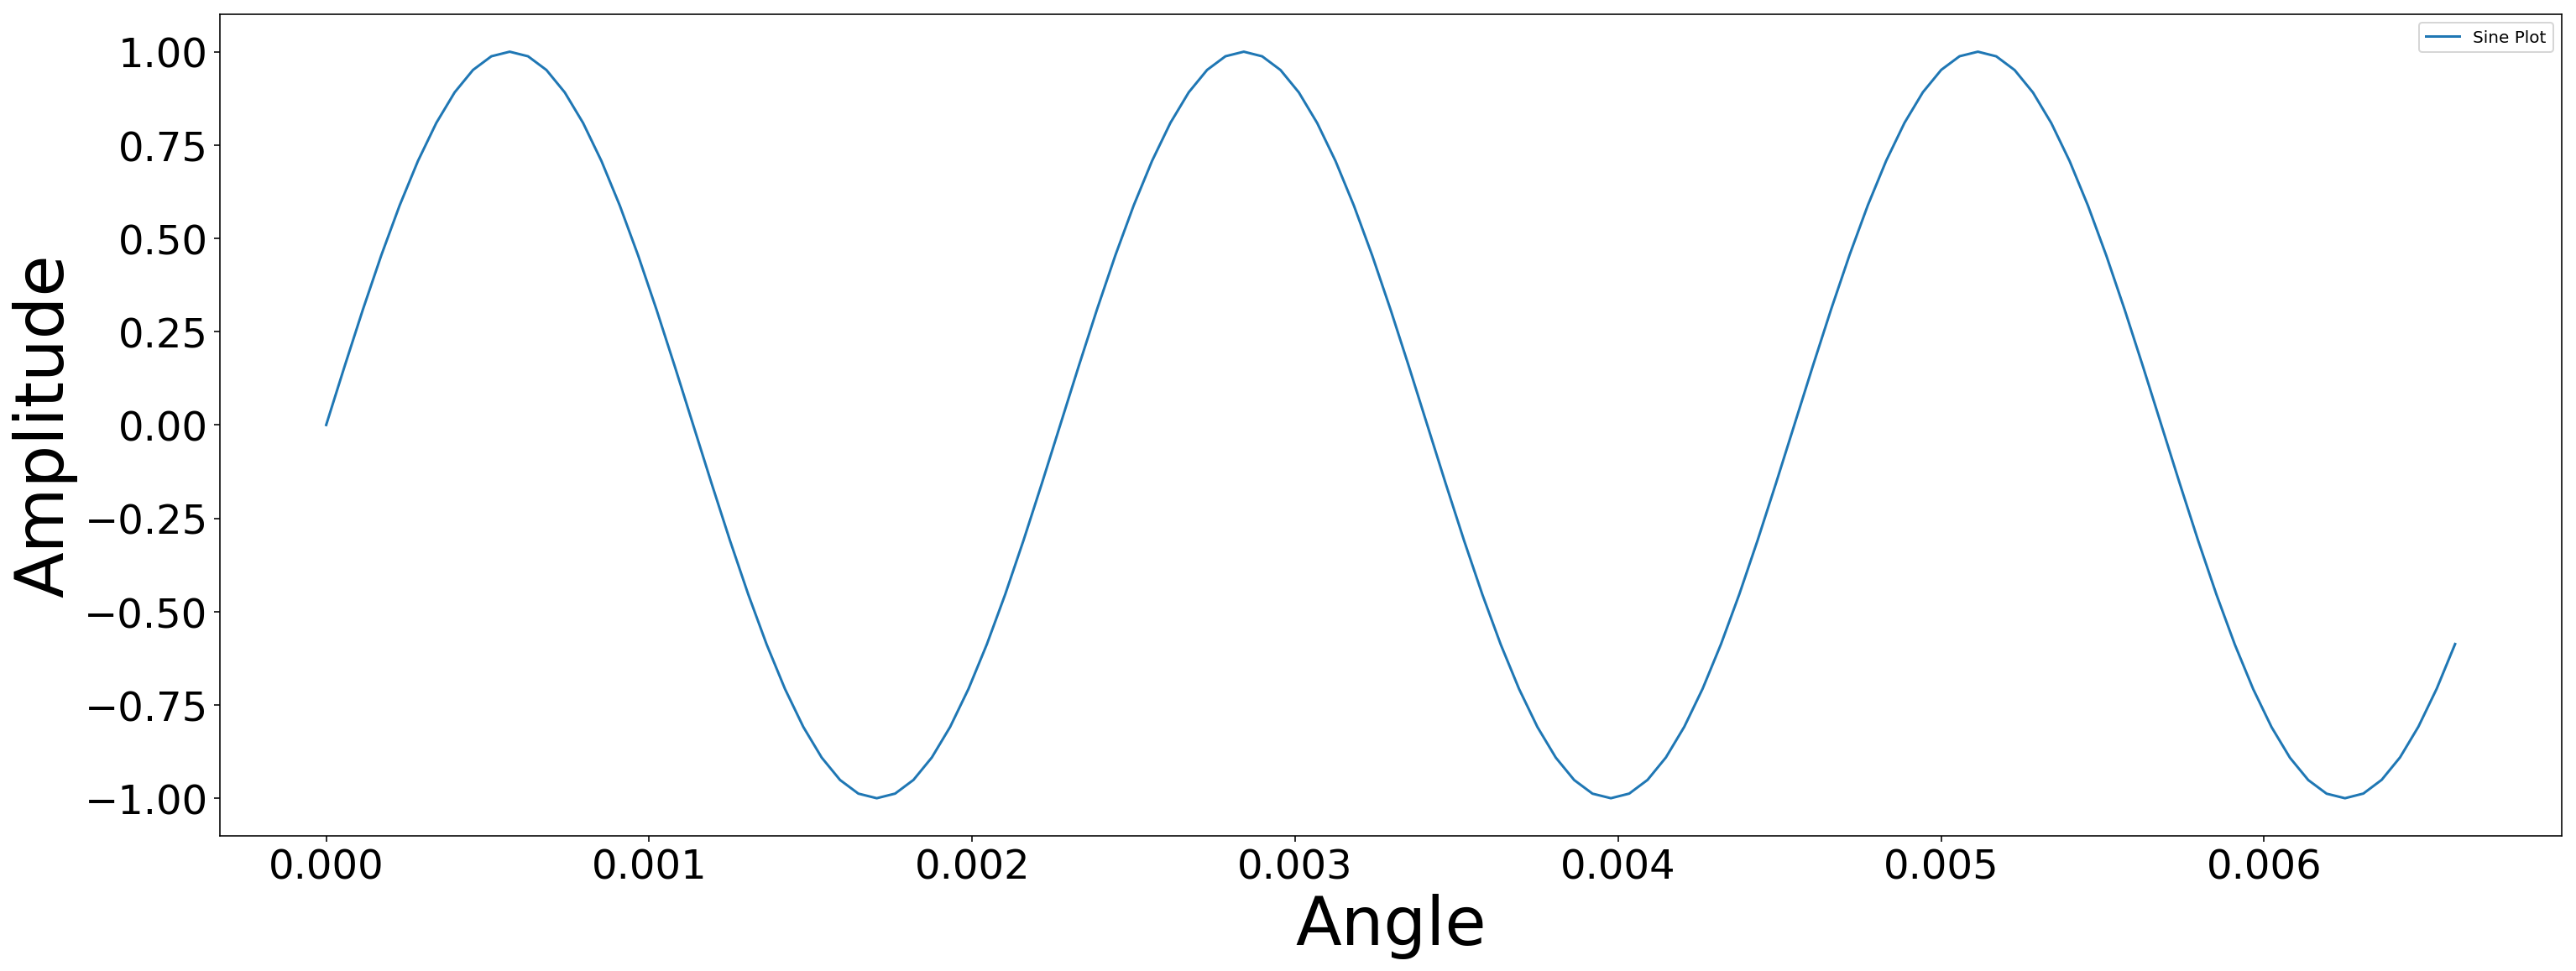

In [56]:
def sin(freq, time = 1, resolution = 10, mx = None):
  #freq in Hz, time in sec
#   x = numpy.arange(0, time, time / (200 * freq))
    if not mx: mx = freq 
    x = numpy.linspace(0, time, 4 * resolution * mx * time)
#   print(x)
    y = numpy.sin(2 * math.pi * x * (freq))

    return x, y

def show(x, y, xlab, ylab, legend, sh = None):
    sh = min((sh * len(x) // 150 , len(x))) if sh else min((len(x) // 150 , len(x)))
    plot(x[:sh], y[:sh], xlab, ylab, legend)
x, y = sin(440)
show(x, y, 'Angle', 'Amplitude', 'Sine Plot')

### superpose :  Superposition of waves
It takes list of notes of music21.note.Note class and applies superposition, combines the pitches together<br>
<b>It applies</b> : <br>
        $$ y(x) = sin(2\pi ax)+sin(2\pi bx)+...+sin(2\pi cx) $$
Here $a, b , ..., c$ are frequencies of wave( Note )

In [57]:
def superpose(xs, time = 1):
    #xs is list of music21.note.Note class
    print(xs)
    f = [nt.pitch.frequency for nt in xs]
    print(f)
    le = min(f)
    mx = max(f)
    x = numpy.linspace(0, time, 4 * 20 * mx)
    res = numpy.zeros(x.shape[0])
    for i in range(0, len(f)):
        y = numpy.sin(2 * math.pi * x * f[i])
    
        res = numpy.add(res, y)
    return x, res

### test : above two function, <i>superpose, sin, plot</i>
If superpose works properly, on C chord (C - E - G)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """


261.6255653005985


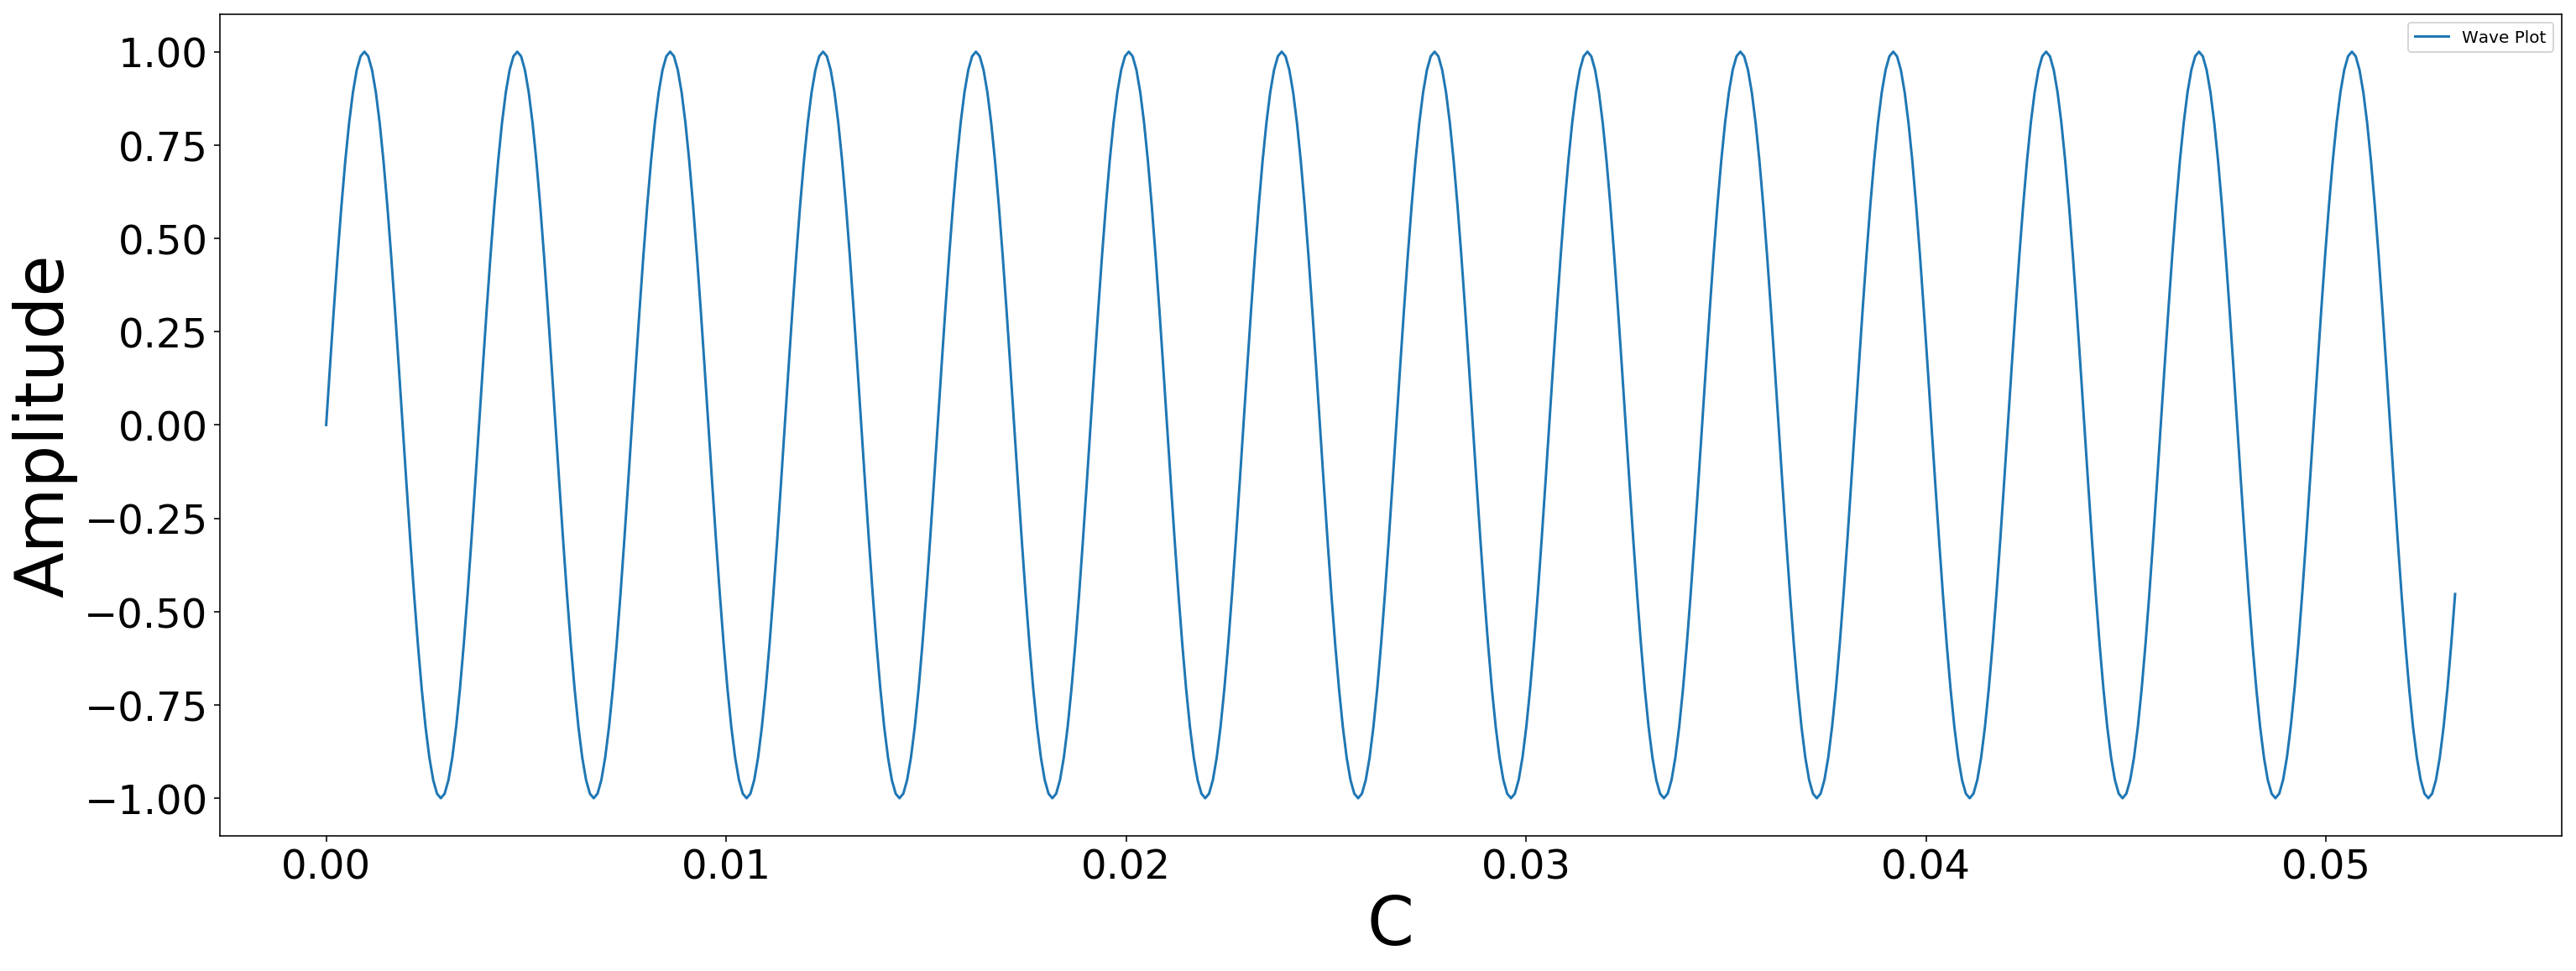

329.62755691286986


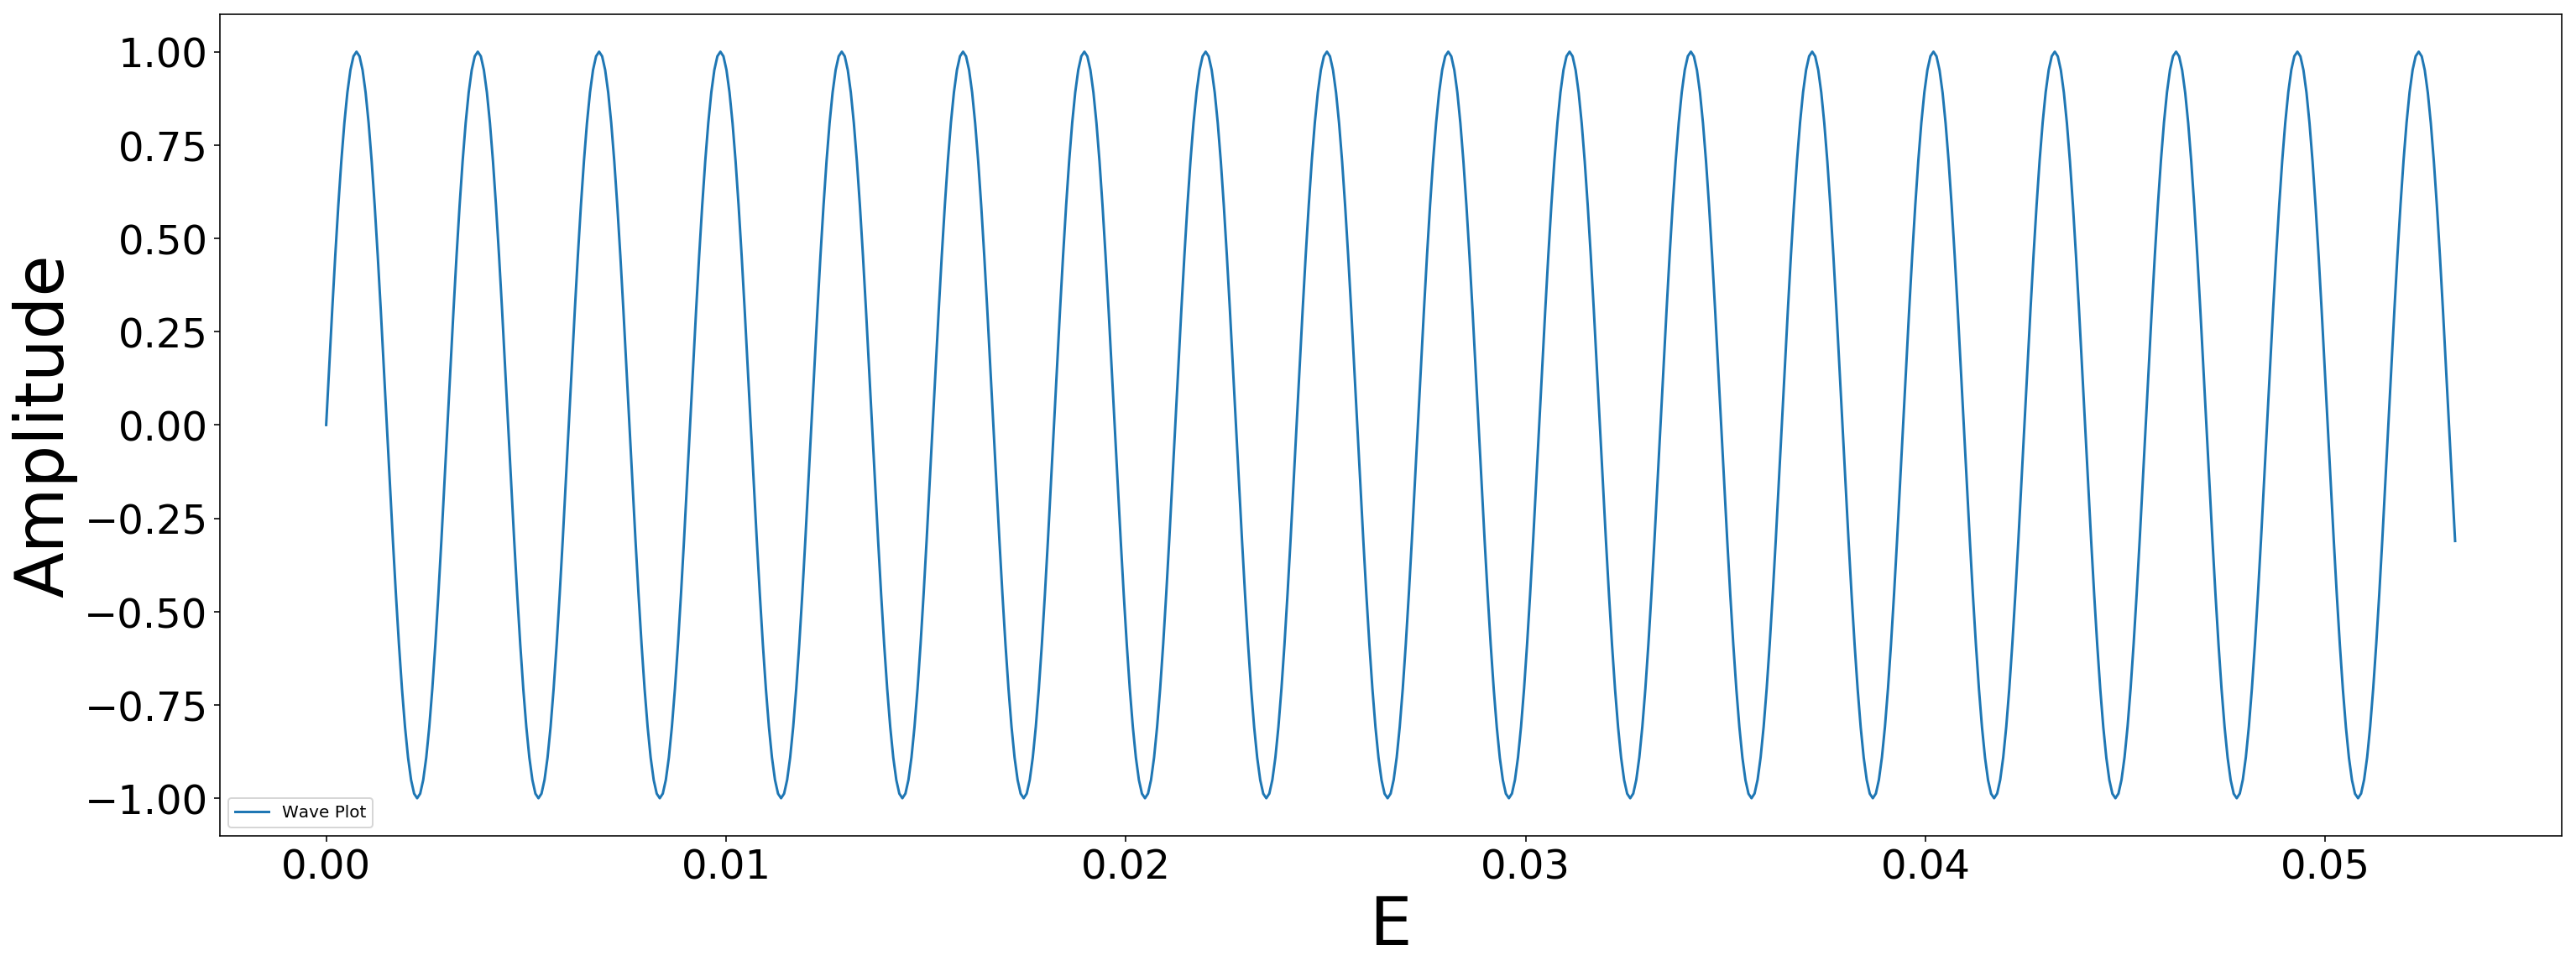

391.99543598174927


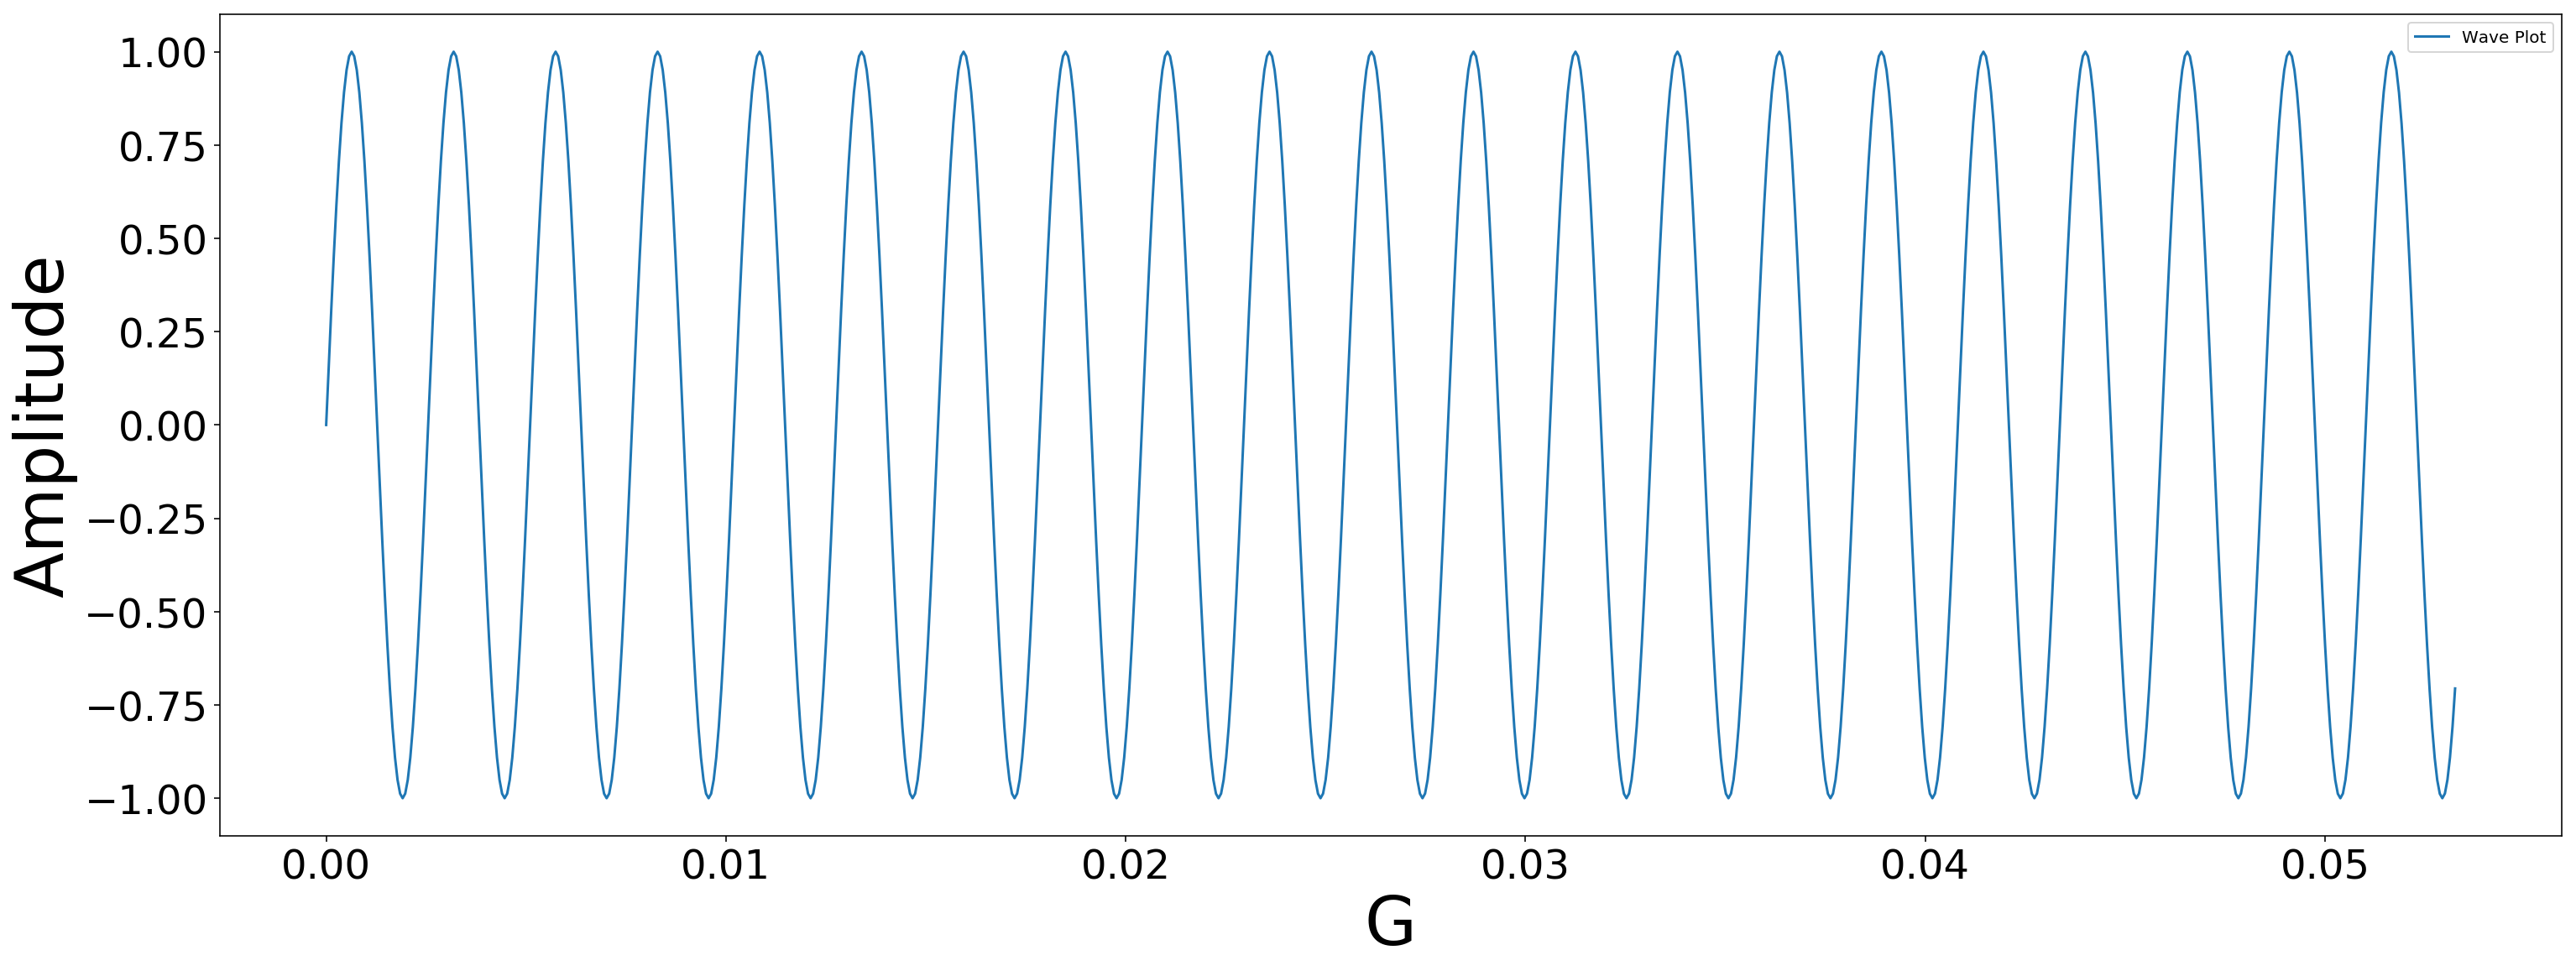

[<music21.note.Note C>, <music21.note.Note E>, <music21.note.Note G>]
[261.6255653005985, 329.62755691286986, 391.99543598174927]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


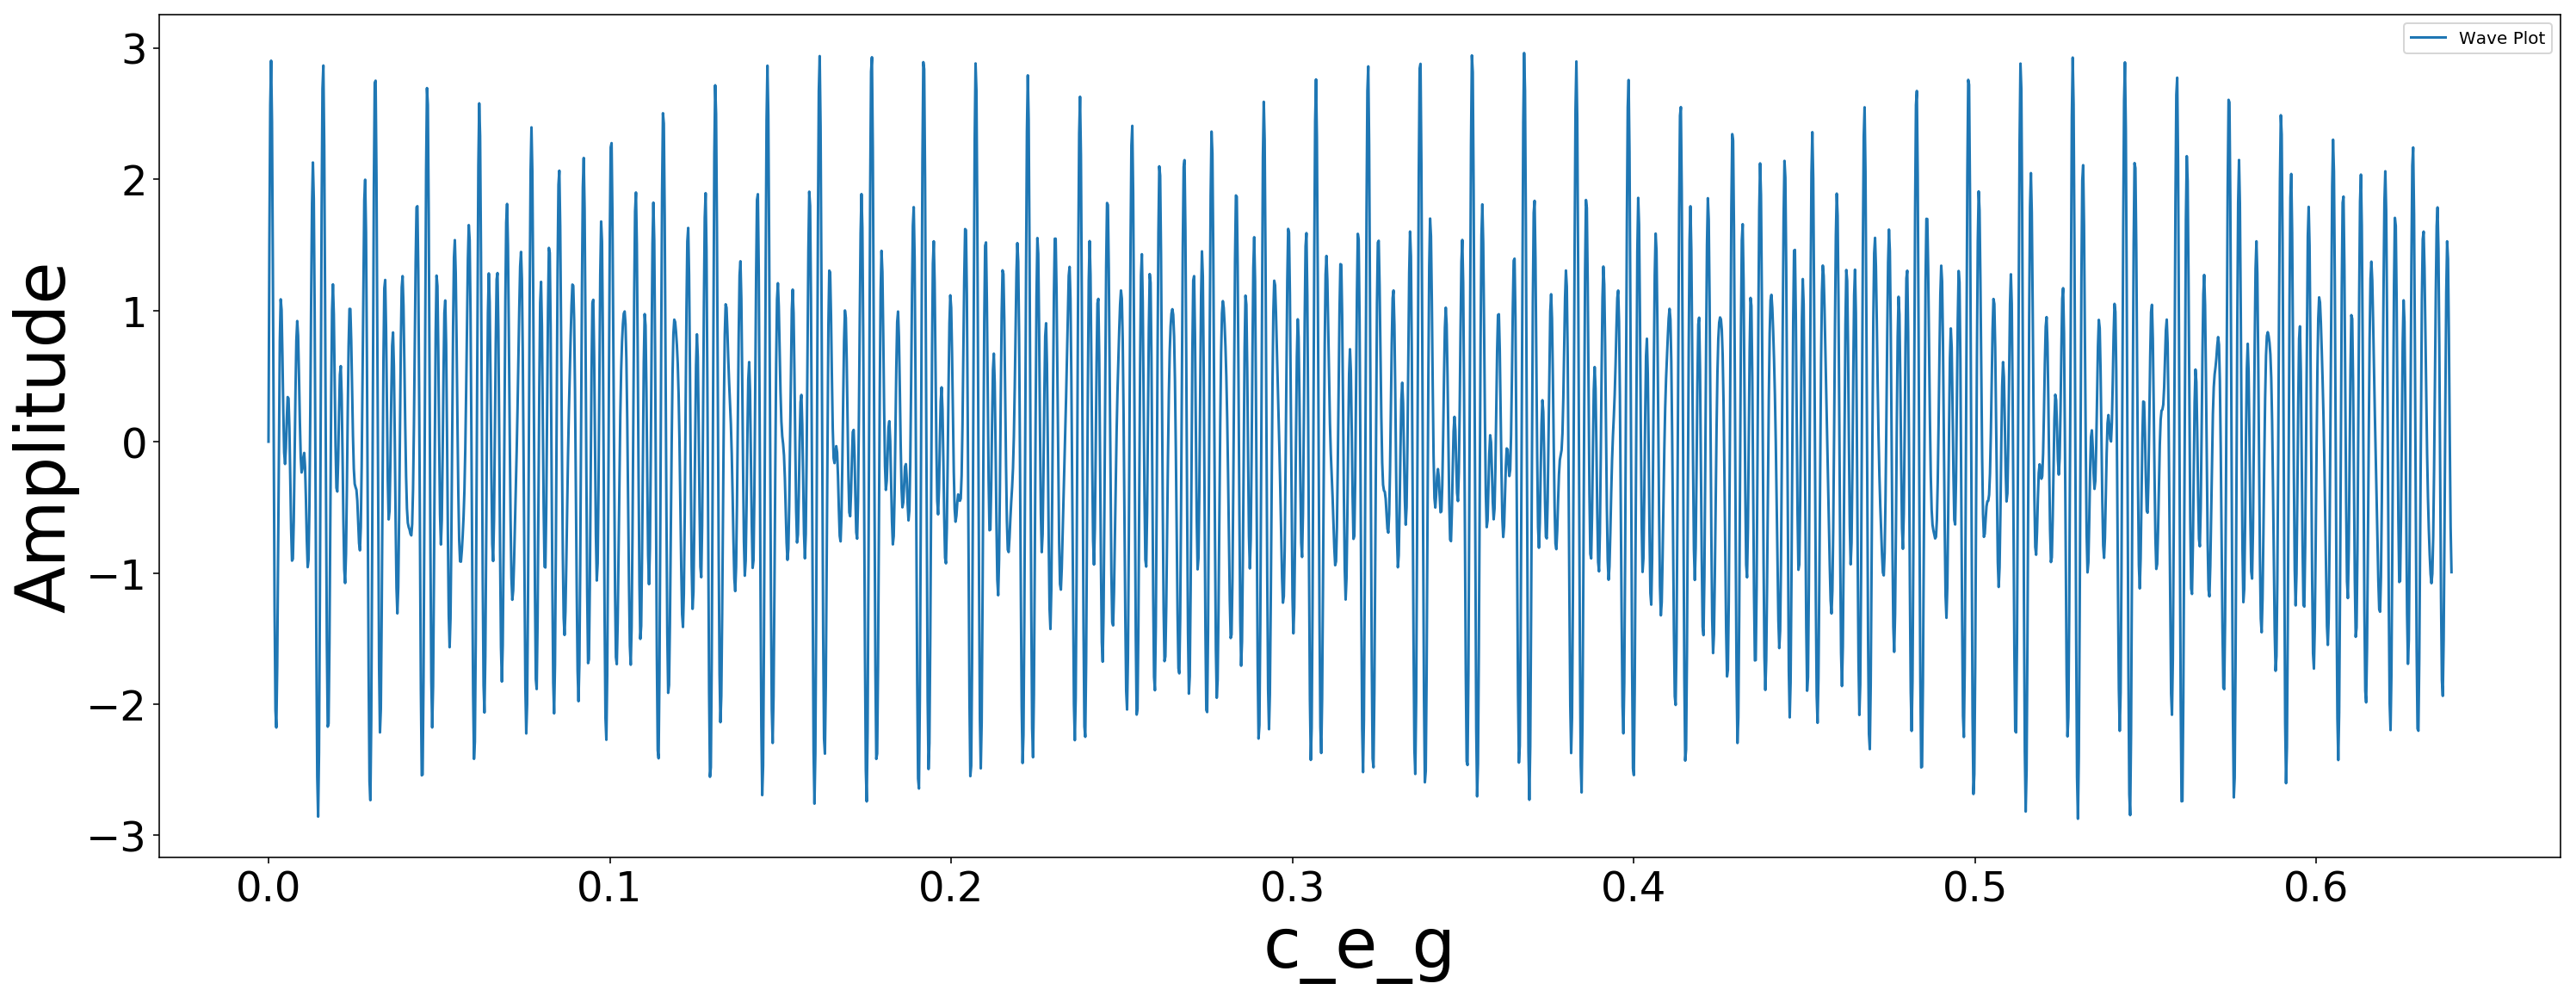

In [98]:
note =[music21.note.Note('c4'), music21.note.Note('e4') , music21.note.Note('g4')]
nx, ny = [], []
for nt in note:
    x, y = sin(nt.pitch.frequency, 8)
    nx.append(x)
    ny.append(y)
    print(nt.pitch.frequency)
    show(x, y, nt.name, 'Amplitude', "Wave Plot")
x, y = superpose(note, 8)
# print(c_e_g[1][100:110])
show(x, y, 'c_e_g', 'Amplitude', "Wave Plot", sh = 1)
# plt.plot(range(100), y[:100])
# plt.show()

### Proposed correlation function for melody matching

For a chord, consist nearly of 5 notes, correlate superpose to individual to give similarity value using correlation coeefficient

**Note :**  Here normal correlation rule like $1$ mean high similarity not use, new rule need to define

In [91]:
le = len(y)
for i in range(2):
    crcf = numpy.corrcoef(y, ny[i][:le])
    print(crcf, "\n")


nyo = numpy.corrcoef(y, ny[0][:le])

print(nyo, "\n")
  
  

[[1.00000000e+00 5.73959206e-05]
 [5.73959206e-05 1.00000000e+00]] 

[[1.00000000e+00 5.38689406e-05]
 [5.38689406e-05 1.00000000e+00]] 

[[1.00000000e+00 5.73959206e-05]
 [5.73959206e-05 1.00000000e+00]] 



### superpose_2w : Superpose the two waves in form of numpy array
$ y_1 = [a_1, a_2, ..., a_n], $ $ x_1 = [t_1, t_2, ..., t_n] $<br>
$ y_2 = [b_1, b_2, ..., b_n],  $  $ x_1 = [s_1, s_2, ..., s_n] $<br>

Then it adjust the results time by taking time intervals of y1, getting y_2 values for that time instance $t_n$ as <br>
            \begin{equation}
            t_n = \frac{y[s_k] + y[s_l]}{2}    \text{ ... where  k $\leq$ n < l  }
            \label{eq:eqn}
            \end{equation}
<br>
Here we take $ n = k$

In [92]:
def superpose_2w(x1, y1, x2, y2):
    res = numpy.zeros(len(x1))
    x_ = copy.deepcopy(x1)
    for i in range(len(x1)):
#         k = numpy.argmax(x2 < x[i])
        l = numpy.argmax(x2 > x_[i])
        res[i] = ( y1[i] + y2[l] ) / 2
    return x_, res

### Test : <i>superpose_2w</i>

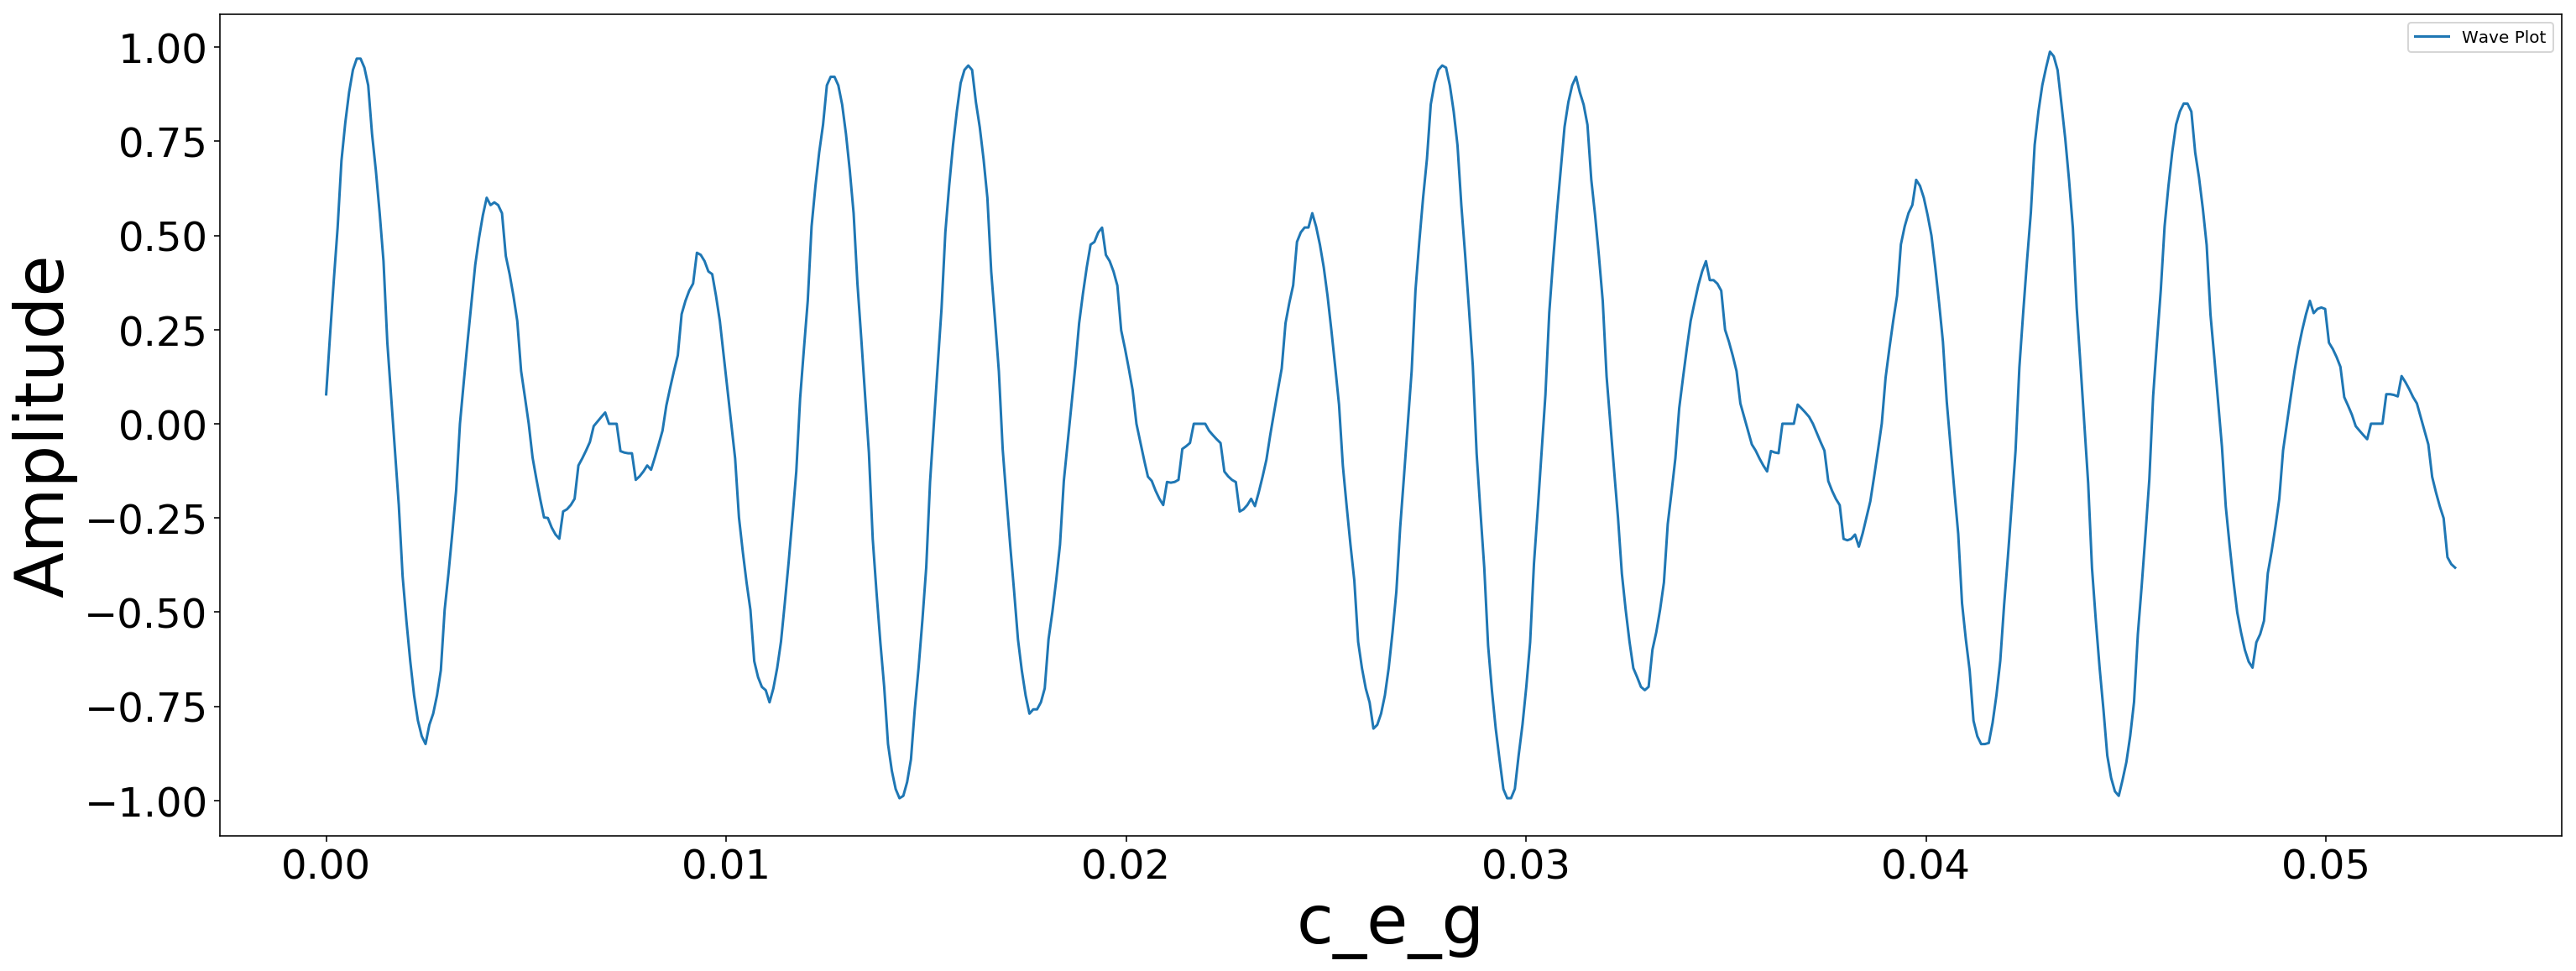

In [93]:
xx, yy = superpose_2w(nx[0], ny[0], nx[1], ny[1])
show(xx, yy, 'c_e_g', 'Amplitude', "Wave Plot", sh = 1)

In [110]:
def superpose_nw(wx, wy):
    #wx, wy are both lists
    x_ = copy.deepcopy(wx[0])
    res = copy.deepcopy(wy[0])
    for i in range(1, len(wx)):
        x_, res = superpose_2w(x_, res, wx[i], wy[i])
    return x_, res

### Test : <i>superpose_nw</i>

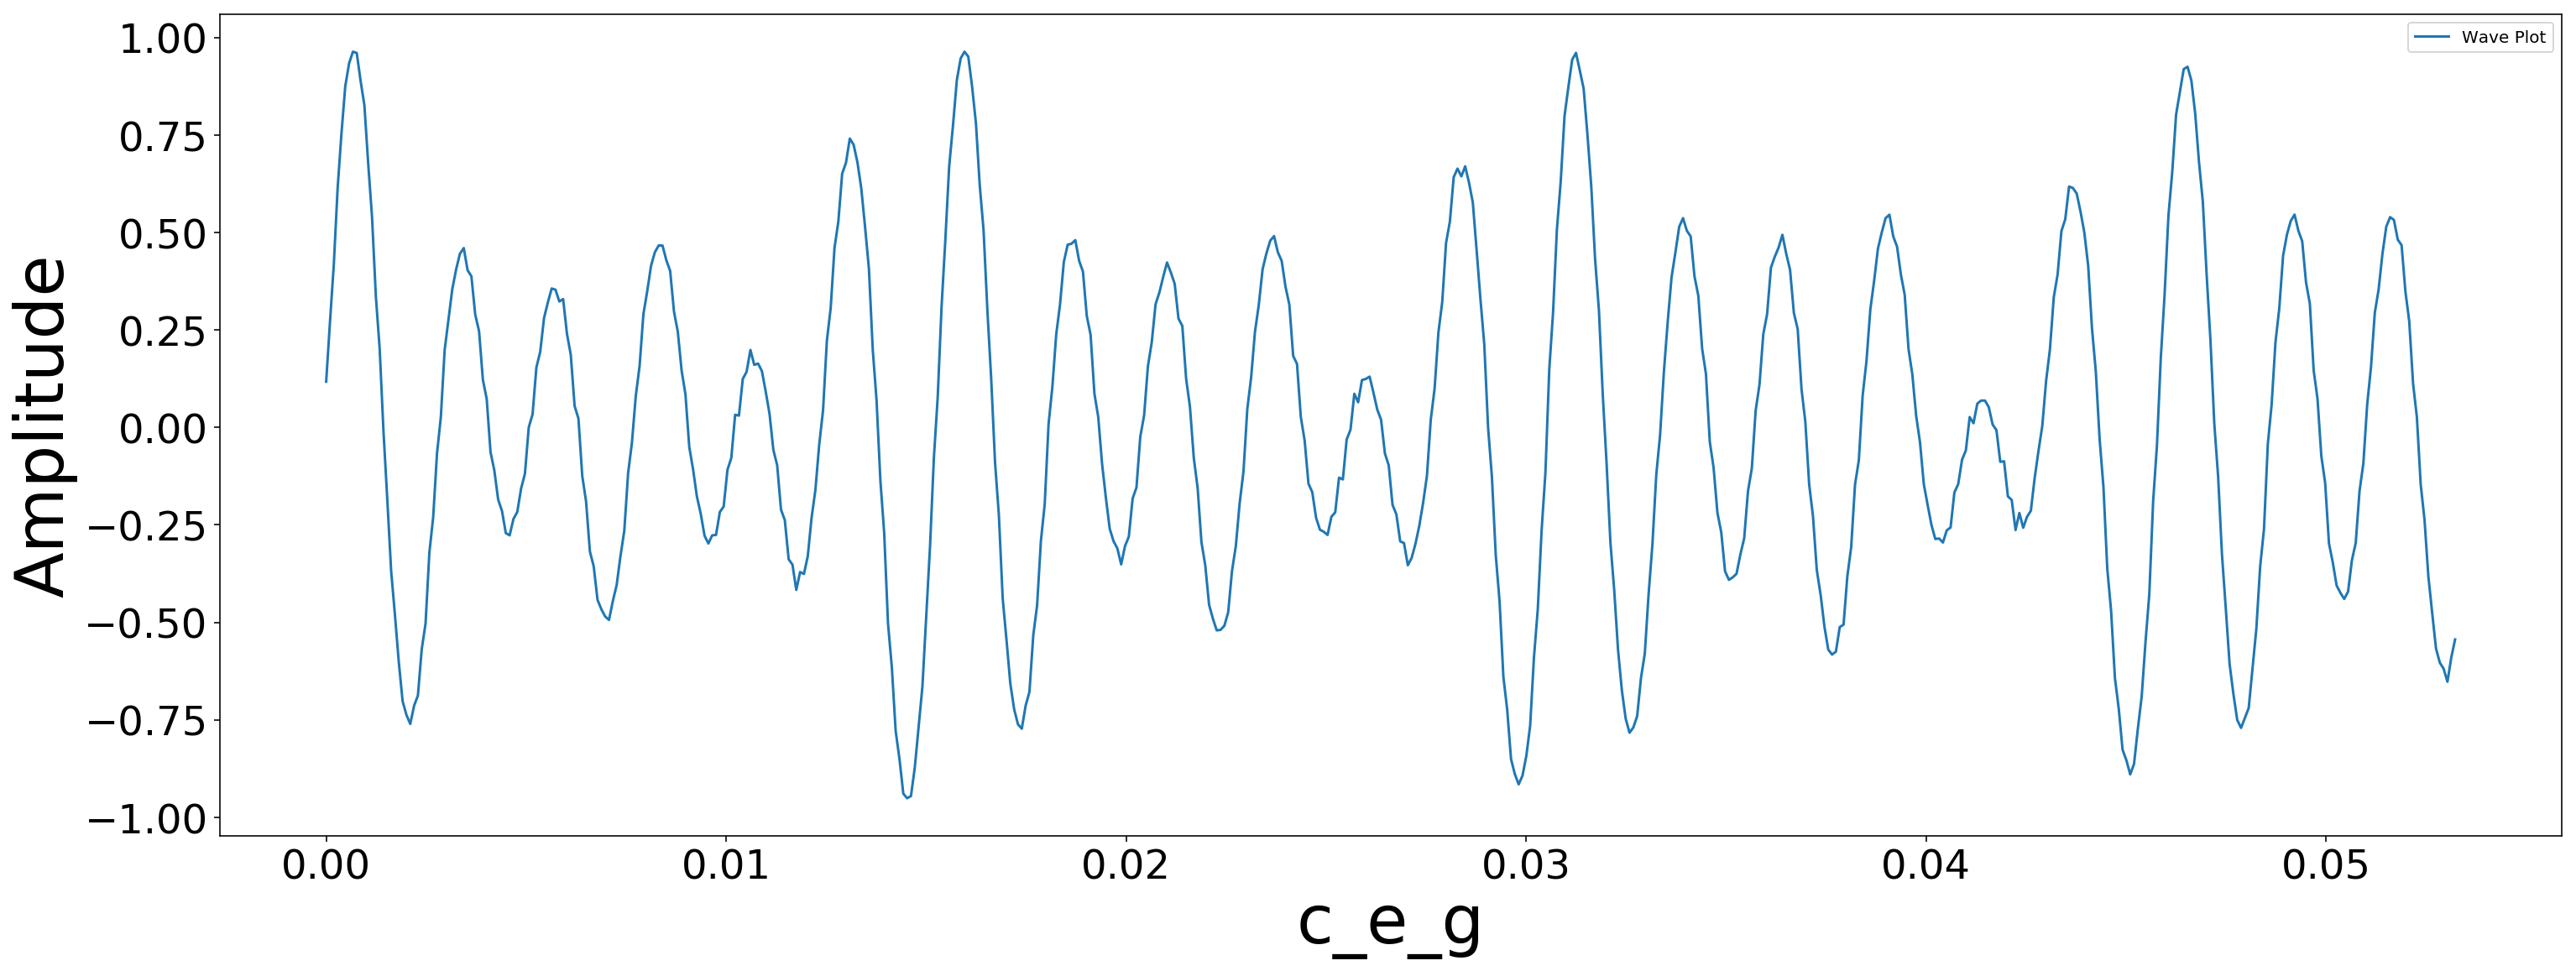

In [111]:
xx, yy = superpose_nw(nx, ny)
show(xx, yy, 'c_e_g', 'Amplitude', "Wave Plot", sh = 1)